# Initial Test

In [1]:
# Necessary imports
import numpy as np
import cv2
from skimage.feature import canny
from skimage.transform import probabilistic_hough_line
from shapely.affinity import affine_transform

# from osgeo import gdal
from shapely.geometry import LineString
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.transform import Affine
import matplotlib.pyplot as plt

### Functions for scripts

In [2]:
def binarise_and_invert_array(arr, binarise_threshold=190):
    """
    Binarizes an image array and inverts the colors so that the background is white
    and features of interest are black.

    Parameters:
    - arr: Input image array (grayscale).
    - binarise_threshold: Threshold for binarizing the image (default is 190).

    Returns:
    - Inverted binary image.
    """
    assert arr.max() <= 255 and arr.min() >= 0
    assert 0 <= binarise_threshold <= 255

    # Binarize the image
    arr_bin = (
        arr < binarise_threshold
    )  # Features become white (True), background black (False)

    # Invert the binary image
    arr_inverted = ~arr_bin  # Features become black (True), background white (False)

    return arr_inverted

In [3]:
def detect_lines(input_image_path, binarise_threshold=190):
    """
    Detect lines in an image using the Canny algorithm and Hough Transform.
    Outputs a GeoDataFrame in pixel space.

    Parameters:
    - input_image_path: Path to the input image file.
    - binarise_threshold: Threshold for binarizing the image (default is 190).

    Returns:
    - gdf: GeoDataFrame with lines in pixel space.
    """
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert("L")  # Convert to grayscale
        image_array = np.array(img)

    # Crop the image to remove border artifacts
    cropped_image = image_array[7:-7, 7:-7]

    # Binarize and invert the image
    binarized_image = binarise_and_invert_array(cropped_image, binarise_threshold)

    # Detect edges using Canny
    edges = canny(binarized_image, sigma=0.9, low_threshold=0.1, high_threshold=0.9)

    # Apply Hough Transform to detect lines
    lines = probabilistic_hough_line(edges, threshold=1, line_length=40, line_gap=10)

    # Convert lines to GeoDataFrame in pixel space
    line_geometries = [
        LineString([(x1, y1), (x2, y2)]) for ((x1, y1), (x2, y2)) in lines
    ]
    gdf = gpd.GeoDataFrame(geometry=line_geometries, crs=None)  # Pixel space, no CRS

    return gdf

In [4]:
# Function to convert lines from pixel space to geographic space
def convert_lines_to_geographic_space(gdf, bounding_box, image_shape, crs="EPSG:4326"):
    """
    Convert lines from pixel space to geographic space.

    Parameters:
    - gdf: GeoDataFrame with lines in pixel space.
    - bounding_box: Tuple (xmin, ymin, xmax, ymax) in geographic space.
    - image_shape: Tuple (width, height) of the image in pixels.
    - crs: CRS for the output GeoDataFrame (default is EPSG:4326).

    Returns:
    - gdf_geographic: GeoDataFrame with lines in geographic space.
    """
    xmin, ymin, xmax, ymax = bounding_box
    width, height = image_shape

    # Calculate scaling factors
    scale_x = (xmax - xmin) / width
    scale_y = (ymax - ymin) / height

    # Map pixel coordinates to geographic coordinates
    def pixel_to_geographic(geom):
        return affine_transform(geom, (scale_x, 0, 0, -scale_y, xmin, ymax))

    # Transform geometry
    gdf_geographic = gdf.copy()
    gdf_geographic["geometry"] = gdf["geometry"].apply(pixel_to_geographic)
    gdf_geographic.crs = crs  # Set CRS to geographic CRS

    return gdf_geographic

In [5]:
#### Rosie there may already be MR code that does this, but I'm not sure where it is! I've not actually looked :) ####


# Function to get metadata for a PNG image
def get_png_metadata(metadata_csv, png_name):
    """
    Extract the metadata for a specific PNG from the metadata CSV file.

    Parameters:
    - metadata_csv: Path to the metadata CSV file.
    - png_name: Name of the PNG file (e.g., "map_101433939.png").

    Returns:
    - metadata: Dictionary containing bounding box and other metadata.
    """
    metadata = pd.read_csv(metadata_csv)
    row = metadata[metadata["name"] == png_name]
    if row.empty:
        raise ValueError(f"No metadata found for {png_name}")

    # Parse the bounding box and return as a dictionary
    coords = eval(row["coordinates"].iloc[0])  # Convert string to tuple
    return {
        "bounding_box": coords,
        "crs": row["crs"].iloc[0],
        "image_name": row["name"].iloc[0],
    }

## Plot functions useful for MapReader?

In [75]:
# Function to plot detected lines
def plot_lines_on_image(input_image_path, gdf):
    """
    Plot detected lines in pixel space on the original image.

    Parameters:
    - input_image_path: Path to the input image file.
    - gdf: GeoDataFrame with lines in pixel space.
    """
    with Image.open(input_image_path) as img:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(img, cmap="gray")

        # Plot the lines
        gdf.plot(ax=ax, color="red", linewidth=1)

        ax.set_title("Detected Lines")
        ax.axis("off")
        plt.show()

In [124]:
def plot_image_and_corrected_binarized(input_image_path, binarise_threshold=190):
    """
    Plot the original image and its corrected binarized version (features as black)
    side by side for visual comparison.

    Parameters:
    - input_image_path: Path to the input image file.
    - binarise_threshold: Threshold for binarizing the image (default is 190).
    """
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert("L")  # Convert to grayscale
        original_image = np.array(img)

    # Crop the image to remove border artifacts
    # cropped_image = original_image[7:-7, 7:-7]

    # Correctly binarize and invert the cropped image
    binarized_image = binarise_and_invert_array(cropped_image, binarise_threshold)

    # Plot the images side by side
    fig, axes = plt.subplots(1, 2, figsize=(21, 21))
    ax = axes.ravel()

    # Original Image
    ax[0].imshow(cropped_image, cmap="gray")
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    # Corrected Binarized Image
    ax[1].imshow(binarized_image, cmap="gray")
    ax[1].set_title(f"Binarized Image (Corrected, Threshold={binarise_threshold})")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

### Testing code

#### Step 1: Detect Lines in Pixel Space

In [6]:
input_image_path = "./data/6_inch_png/map_101433990.png"

# Detect lines in pixel space
gdf_pixel = detect_lines(input_image_path, binarise_threshold=190)
print(gdf_pixel.head())

NameError: name 'Image' is not defined

#### Step 2: Convert Lines to Geographic Space (Optional)

In [119]:
# Metadata CSV
metadata_csv = "./data/6_inch_png/metadata.csv"

# Get metadata
metadata = get_png_metadata(metadata_csv, input_image_path.split("/")[-1])
bounding_box = metadata["bounding_box"]

# Convert lines to geographic space
image_shape = Image.open(input_image_path).size
gdf_geographic = convert_lines_to_geographic_space(gdf_pixel, bounding_box, image_shape)

# Print results
print(gdf_geographic.head())

                                            geometry
0  LINESTRING (-0.63775 51.04524, -0.63827 51.04524)
1  LINESTRING (-0.64427 51.03751, -0.64493 51.03751)
2  LINESTRING (-0.64214 51.05697, -0.64258 51.05697)
3  LINESTRING (-0.61217 51.06306, -0.61122 51.06360)
4  LINESTRING (-0.65046 51.05754, -0.65091 51.05772)


#### Step 3: Save as Shapefile (Optional)

In [120]:
output_shapefile = "./output/lines_geographic_space.shp"
gdf_geographic.to_file(output_shapefile)

#### Step 4: Plot the Detected Lines

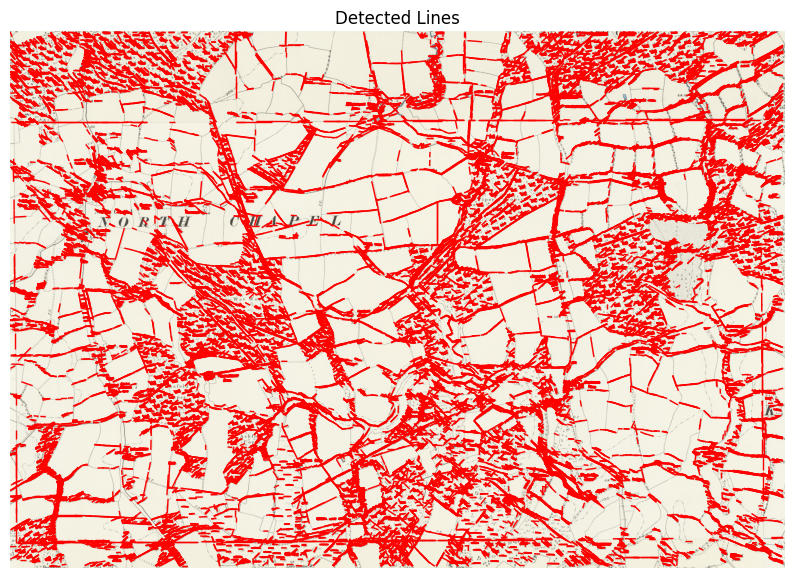

In [125]:
# Plot the detected lines in pixel space
plot_lines_on_image(input_image_path, gdf_pixel)

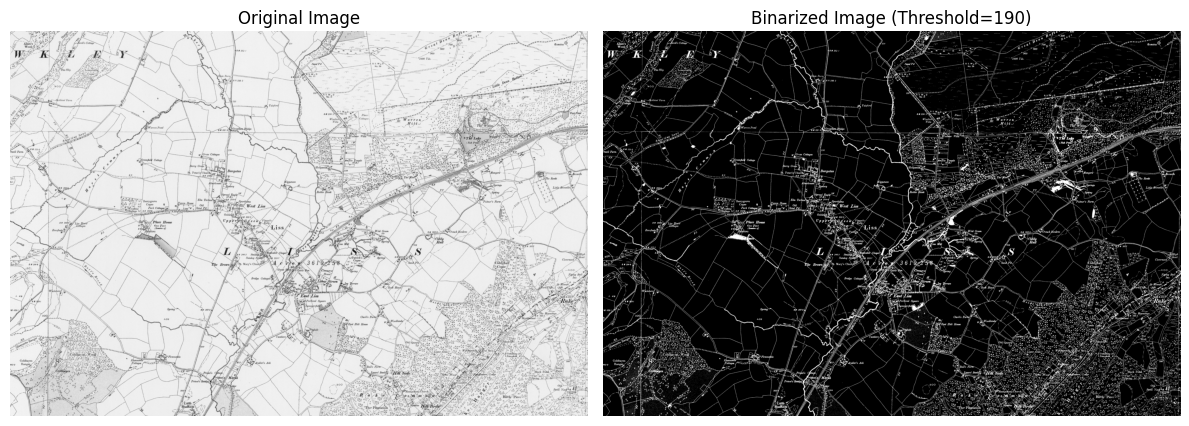

In [107]:
# Define the input image path
input_image_path = "./data/6_inch_png/map_101433939.png"

# Plot the original and binarized images side by side
plot_image_and_binarized(input_image_path, binarise_threshold=190)

In [114]:
def visualize_preprocessing(input_image_path, binarise_threshold=190):
    """
    Visualize the original image, binarized image, edge-detected image, and detected lines.

    Parameters:
    - input_image_path: Path to the input image file.
    - binarise_threshold: Threshold for binarizing the image (default is 190).
    """
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert("L")  # Convert to grayscale
        image_array = np.array(img)

    # Crop the image to remove border artifacts
    cropped_image = image_array[7:-7, 7:-7]

    # Binarize and invert the image
    binarized_image = binarise_and_invert_array(cropped_image, binarise_threshold)

    # Detect edges using Canny with original parameters
    edges = canny(binarized_image, sigma=0.9, low_threshold=0.1, high_threshold=0.9)

    # Detect lines using Hough Transform
    gdf_pixel = detect_lines(input_image_path, binarise_threshold)

    # Plot the results
    fig, axes = plt.subplots(1, 4, figsize=(20, 6))
    ax = axes.ravel()

    # Original Image
    ax[0].imshow(cropped_image, cmap="gray")
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    # Binarized Image
    ax[1].imshow(binarized_image, cmap="gray")
    ax[1].set_title("Binarized (Inverted) Image")
    ax[1].axis("off")

    # Edge-detected Image
    ax[2].imshow(edges, cmap="gray")
    ax[2].set_title("Edge-Detected Image")
    ax[2].axis("off")

    # Detected Lines
    ax[3].imshow(cropped_image, cmap="gray")
    for line in gdf_pixel.geometry:
        x, y = line.xy
        ax[3].plot(x, y, color="red")
    ax[3].set_title("Detected Lines")
    ax[3].axis("off")

    plt.tight_layout()
    plt.show()

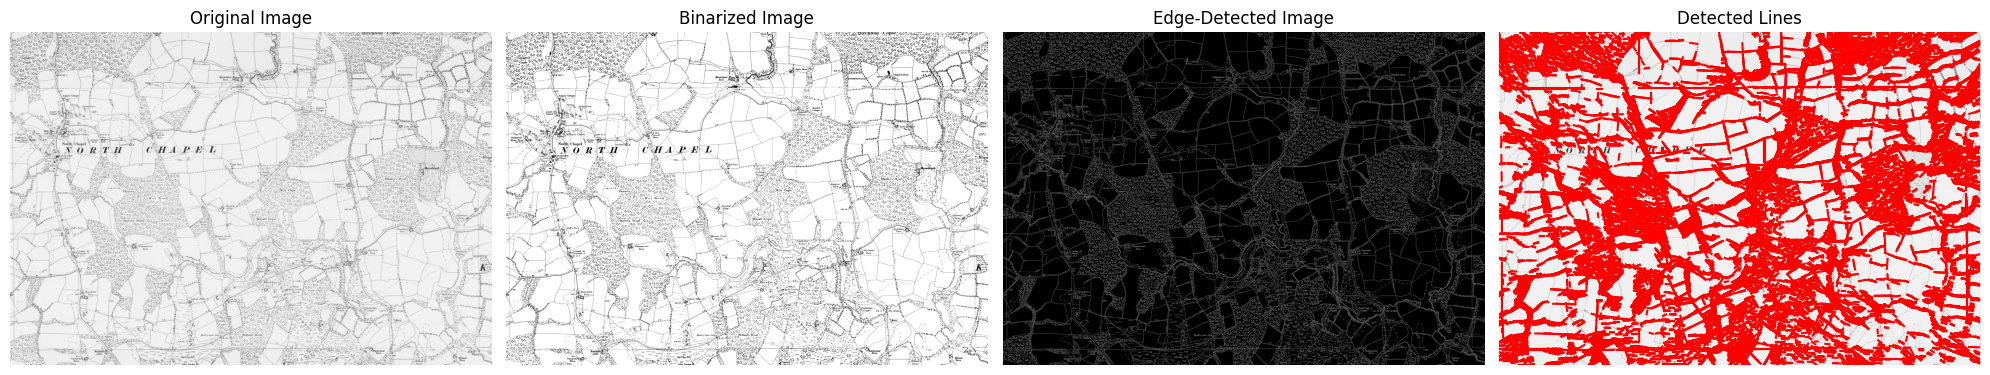

In [117]:
input_image_path = "./data/6_inch_png/map_101433990.png"

# Visualize the preprocessing steps
visualise_preprocessing(input_image_path, binarise_threshold=190)

# Lets try and reprocess → Threshold → Extract Contours → Vectorize → Post-Process

In [7]:
import math
import cv2
import numpy as np
import geopandas as gpd
from shapely.geometry import LineString
import rasterio
from shapely.geometry import LineString, MultiLineString
from shapely.ops import unary_union
from skimage.morphology import skeletonize
from skimage.util import img_as_bool

In [10]:
# File paths
input_tif = "./output/masked_map_101433939.tif"
output_geojson = "./output/field_boundaries_40.geojson"

In [9]:
def binarize_image(image, threshold_type="adaptive", block_size=15, C=10):
    """
    Binarize a grayscale image using different methods.
    """
    if threshold_type == "otsu":
        _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    elif threshold_type == "adaptive":
        binary = cv2.adaptiveThreshold(
            image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, C
        )
    else:
        _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    return binary


def extract_contours(binary_image):
    """
    Extract contours from a binary image using OpenCV.
    """
    contours, _ = cv2.findContours(binary_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    return contours


def contours_to_geodataframe(
    contours, transform, min_length=10, simplify_tolerance=0.5
):
    """
    Convert contours to a GeoDataFrame with LineString geometries, applying refinements.
    """
    lines = []
    for contour in contours:
        if len(contour) > 1:
            # Convert pixel to geospatial coordinates
            line = [
                transform * (int(point[0][0]), int(point[0][1])) for point in contour
            ]
            line_string = LineString(line)

            # Filter short lines
            if line_string.length > min_length:
                # Simplify lines
                line_string = line_string.simplify(simplify_tolerance)
                lines.append(line_string)

    # Merge connected lines (optional)
    merged_lines = gpd.GeoSeries(lines).unary_union

    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=[merged_lines], crs="EPSG:27700")
    return gdf


def main(input_tif, output_geojson):
    # Open the input TIFF file
    with rasterio.open(input_tif) as src:
        # Read the first band (assuming single-channel greyscale image)
        image = src.read(1)
        transform = src.transform

    # Step 1: Binarize the image
    binary_image = binarize_image(image, threshold_type="adaptive")

    # Step 2: Extract contours
    contours = extract_contours(binary_image)

    # Step 3: Convert contours to vector (GeoJSON)
    gdf = contours_to_geodataframe(contours, transform)

    # Step 4: Save to GeoJSON
    gdf.to_file(output_geojson, driver="GeoJSON")
    print(f"Saved vector data to {output_geojson}")


if __name__ == "__main__":
    main(input_tif, output_geojson)

Saved vector data to ./output/field_boundaries_39.geojson


In [ ]:
# Lets try and save the binarized images

In [35]:
import rasterio
import numpy as np
import cv2

def binarize_image(image, threshold=210):
    """
    Binarize image based on a threshold.
    """
    binary = np.where(image < threshold, 1, 0).astype(np.uint8)
    return binary

def save_binarized_tif(input_tif, output_tif, threshold=210):
    """
    Binarizes an input TIFF and saves it as a new TIFF.
    """
    # Open the original TIFF
    with rasterio.open(input_tif) as src:
        image = src.read(1)  # Read first band
        profile = src.profile

    # Apply binarization
    binary_image = binarize_image(image, threshold)

    # Update metadata for binary output
    profile.update(dtype=rasterio.uint8, count=1)

    # Save the binarized image as a new TIFF
    with rasterio.open(output_tif, 'w', **profile) as dst:
        dst.write(binary_image, 1)

    print(f"✅ Binarized TIFF saved to: {output_tif}")

# === FILE PATHS ===
input_tif = "./output/masked_map_101433939.tif"
output_tif = "./output/binarized_map_210.tif"

# === RUN SCRIPT ===
save_binarized_tif(input_tif, output_tif, threshold=210)


✅ Binarized TIFF saved to: ./output/binarized_map_210.tif


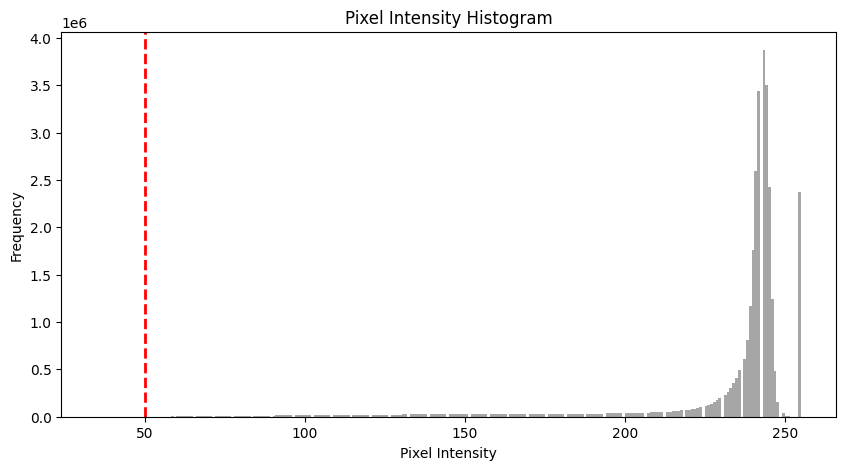

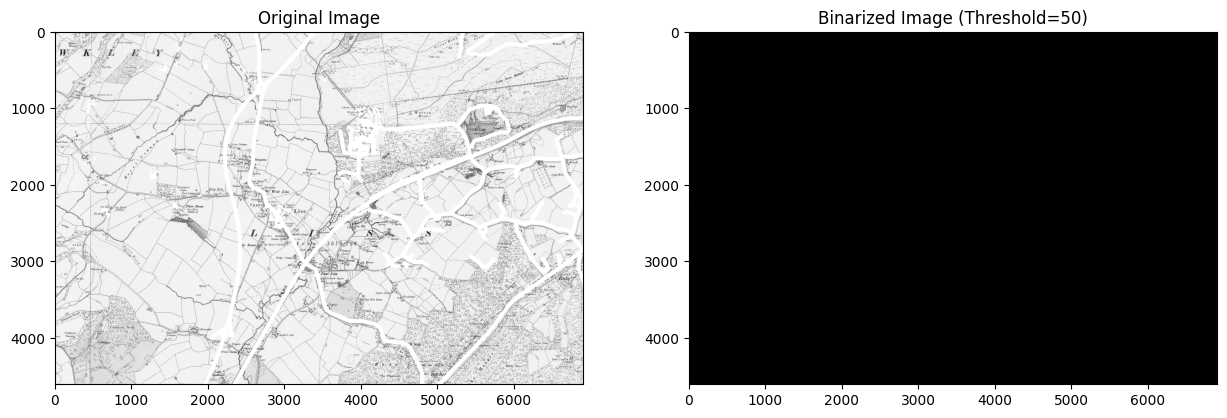

✅ Binarized TIFF saved to: ./output/binarized_map_analysis50.tif


In [39]:
import rasterio
import numpy as np
import cv2
import matplotlib.pyplot as plt

def binarize_image(image, threshold=50):
    """
    Binarize image based on a threshold.
    """
    binary = np.where(image < threshold, 1, 0).astype(np.uint8)
    return binary

def save_binarized_tif(input_tif, output_tif, threshold=50):
    """
    Binarizes an input TIFF and saves it as a new TIFF.
    """
    # Open the original TIFF
    with rasterio.open(input_tif) as src:
        image = src.read(1)  # Read first band
        profile = src.profile

    # Plot histogram of pixel values to determine threshold
    plt.figure(figsize=(10, 5))
    plt.hist(image.flatten(), bins=256, color='gray', alpha=0.7)
    plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2)
    plt.title("Pixel Intensity Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

    # Apply binarization
    binary_image = binarize_image(image, threshold)

    # Visualize original and binarized images
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("Original Image")
    axes[1].imshow(binary_image, cmap='gray')
    axes[1].set_title(f"Binarized Image (Threshold={threshold})")
    plt.show()

    # Update metadata for binary output
    profile.update(dtype=rasterio.uint8, count=1)

    # Save the binarized image as a new TIFF
    with rasterio.open(output_tif, 'w', **profile) as dst:
        dst.write(binary_image, 1)

    print(f"✅ Binarized TIFF saved to: {output_tif}")

# === FILE PATHS ===
input_tif = "./output/masked_map_101433939.tif"
output_tif = "./output/binarized_map_analysis50.tif"

# === RUN SCRIPT ===
save_binarized_tif(input_tif, output_tif, threshold=50)


✅ Detailed polylines saved to: ./output/detailed_vectorized_lines.geojson


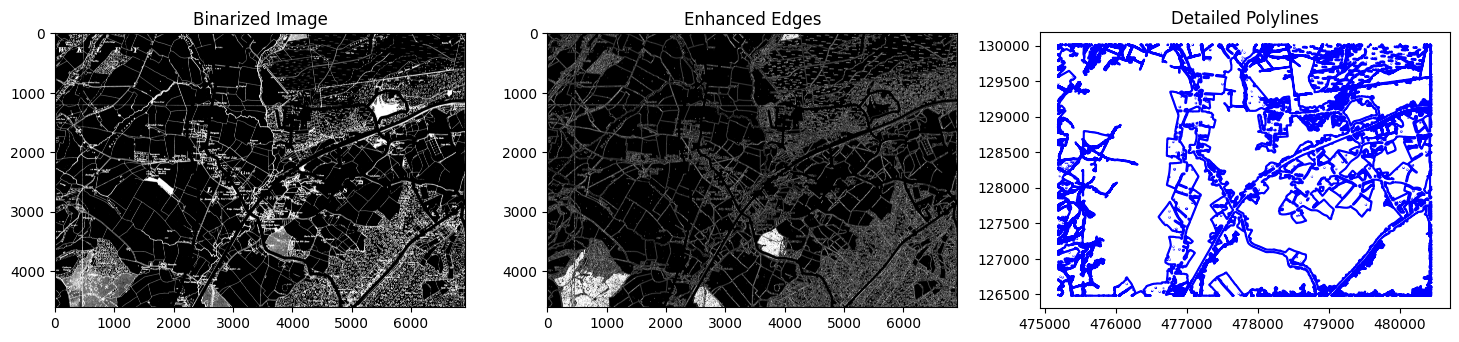

In [43]:
import rasterio
import numpy as np
import cv2
import geopandas as gpd
from shapely.geometry import LineString
import matplotlib.pyplot as plt

def enhance_and_extract_detailed_lines(binarized_tif, output_geojson, canny_thresh1=30, canny_thresh2=100, kernel_size=5, simplify_tolerance=0.1):
    """
    Enhances and extracts detailed lines from the binarized TIFF and saves as polylines.
    """
    # Read the binarized TIFF
    with rasterio.open(binarized_tif) as src:
        binary_image = src.read(1)
        transform = src.transform

    # Apply Adaptive Thresholding for finer control
    adaptive_binary = cv2.adaptiveThreshold(
        (binary_image * 255).astype(np.uint8),
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        15,
        10
    )

    # Apply Canny edge detection
    edges = cv2.Canny(adaptive_binary, canny_thresh1, canny_thresh2)

    # Morphological closing to fill gaps
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    # Find contours with NO approximation for more detailed lines
    contours, _ = cv2.findContours(closed_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Convert contours to LineStrings
    lines = []
    for contour in contours:
        if len(contour) > 1:
            # Convert pixel to geospatial coordinates
            coords = [transform * (point[0][0], point[0][1]) for point in contour]
            line = LineString(coords)
            # Apply minimal simplification
            simplified_line = line.simplify(simplify_tolerance)
            lines.append(simplified_line)

    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=lines, crs="EPSG:27700")

    # Save to GeoJSON
    gdf.to_file(output_geojson, driver="GeoJSON")
    print(f"✅ Detailed polylines saved to: {output_geojson}")

    # Plot for visualization
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    axs[0].imshow(binary_image, cmap='gray')
    axs[0].set_title("Binarized Image")
    axs[1].imshow(closed_edges, cmap='gray')
    axs[1].set_title("Enhanced Edges")
    axs[2].set_title("Detailed Polylines")
    gdf.plot(ax=axs[2], color='blue')
    plt.show()

# === FILE PATHS ===
binarized_tif = "./output/binarized_map_analysis220.tif"
output_geojson = "./output/detailed_vectorized_lines.geojson"

# === RUN SCRIPT ===
enhance_and_extract_detailed_lines(binarized_tif, output_geojson, canny_thresh1=20, canny_thresh2=180, kernel_size=3, simplify_tolerance=0.05)
